## 오토바이 데이터를 이용한 다중선형회귀분석

## import and Load data

In [642]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [643]:
data = pd.read_excel('./archive/Bike_Price_Prediction.xlsx', sheet_name=0)

In [644]:
data

,S.no,Bike_company,Bike_model,Manufactured_year,Engine_warranty,Engine_type,Fuel_type,CC(Cubic capacity),Fuel_Capacity,Price
0,1,Bajaj,Avenger 220,2020,5.0,Single,Petrol,220CC,10 Litres,113000
1,2,TVS,Apache RTR,2020,5.0,V-twin,Petrol,120CC,11 Litres,70000
2,3,Hero,Passion,2020,5.0,Boxer,Petrol,140CC,12 Litres,85000
3,4,Honda,Activa 3G,2020,5.0,Single,Petrol,150CC,13 Litres,90000
4,5,Suzuki,Access,2020,5.0,V-twin,Petrol,350CC,14 Litres,65000
...,...,...,...,...,...,...,...,...,...,...
303,304,Bgauss,Bgauss B8,2017,3.0,Boxer,Petrol,185CC,19 Litres,81916
304,305,Bgauss,Bgauss Radiator,2017,3.0,Boxer,Petrol,205CC,20 Litres,82666
305,306,Bgauss,Bgauss Razor,2017,3.0,Boxer,Petrol,185CC,21 Litres,83416
306,307,Bgauss,Bgauss Flash,2017,3.0,Boxer,Petrol,205CC,22 Litres,84166


In [645]:
data=data.drop(columns=['S.no','Bike_company','Bike_model']) #데이터 예측에 의미가 없는 컬럼 삭제
data=data.dropna(axis=0) #데이터 정합성을 위해 데이터가 비워저 있는 행 삭제
data=data[data.Manufactured_year > 2010] #데이터 정합성을 위해 2010년도 이전 데이터행 삭제
data["CC(Cubic capacity)"] = data["CC(Cubic capacity)"].str.replace(pat='CC', repl=r'', regex=True) #CC컬럼의 'CC'가 붙어있는 문자 삭제
data["Fuel_Capacity"] = data["Fuel_Capacity"].str.replace(pat=' Litres', repl=r'', regex=True) #연료컬럼의 붙어있는 문자 삭제
data["Fuel_Capacity"] = data["Fuel_Capacity"].str.replace(pat='Battery', repl='0', regex=True) #연료컬럼의 '배터리'를 '0'으로 변환(Fuel_type에서 전기오토바이는 식별 가능)

In [646]:
data

,Manufactured_year,Engine_warranty,Engine_type,Fuel_type,CC(Cubic capacity),Fuel_Capacity,Price
0,2020,5.0,Single,Petrol,220,10,113000
1,2020,5.0,V-twin,Petrol,120,11,70000
2,2020,5.0,Boxer,Petrol,140,12,85000
3,2020,5.0,Single,Petrol,150,13,90000
4,2020,5.0,V-twin,Petrol,350,14,65000
...,...,...,...,...,...,...,...
303,2017,3.0,Boxer,Petrol,185,19,81916
304,2017,3.0,Boxer,Petrol,205,20,82666
305,2017,3.0,Boxer,Petrol,185,21,83416
306,2017,3.0,Boxer,Petrol,205,22,84166


In [647]:
data['Engine_type'].replace({'Boxer':1, 'Dual Stroke':2, 'Oxidiser-Air inlet':3, 'Single':4, 'Two-Stroke':5, 'V-twin':6},inplace=True)
#해당 엔진타입을 넣고 모델 학습결과 예측값에 상관없이 회귀계수가 나와 해당 데이터 삭제 
data['Fuel_type'].replace({'Petrol':1, 'Electricity':2},inplace=True)
data.dtypes

Manufactured_year       int64
Engine_warranty       float64
Engine_type             int64
Fuel_type               int64
CC(Cubic capacity)     object
Fuel_Capacity          object
Price                   int64
dtype: object

In [648]:
data = data.astype(dtype='int64', errors='ignore') #변경 가능한 data type을 int형으로 변경
data.dtypes

Manufactured_year     int64
Engine_warranty       int64
Engine_type           int64
Fuel_type             int64
CC(Cubic capacity)    int64
Fuel_Capacity         int64
Price                 int64
dtype: object

In [649]:
data

,Manufactured_year,Engine_warranty,Engine_type,Fuel_type,CC(Cubic capacity),Fuel_Capacity,Price
0,2020,5,4,1,220,10,113000
1,2020,5,6,1,120,11,70000
2,2020,5,1,1,140,12,85000
3,2020,5,4,1,150,13,90000
4,2020,5,6,1,350,14,65000
...,...,...,...,...,...,...,...
303,2017,3,1,1,185,19,81916
304,2017,3,1,1,205,20,82666
305,2017,3,1,1,185,21,83416
306,2017,3,1,1,205,22,84166


In [650]:
data = data[['Manufactured_year','Engine_warranty','Engine_type','Fuel_type','CC(Cubic capacity)','Fuel_Capacity','Price']].values
# (기존) xlsx 형식의 데이터를 .values를 통해 -> (변경) array형으로 변환  ,'Engine_type' ->제외

In [651]:
data

array([[  2020,      5,      4, ...,    220,     10, 113000],
       [  2020,      5,      6, ...,    120,     11,  70000],
       [  2020,      5,      1, ...,    140,     12,  85000],
       ...,
       [  2017,      3,      1, ...,    185,     21,  83416],
       [  2017,      3,      1, ...,    205,     22,  84166],
       [  2017,      3,      1, ...,    220,     23,  84916]], dtype=int64)

### Split Data: Train data, Validation Data

In [652]:
train_len = 240 #전체 data의 80% 를 훈련데이터로 사용
train_idxs = np.random.choice(len(data), train_len, replace=False) #index정의
train_data = data[train_idxs] 
#위file data에 index형식에 맞게 뽑아 train_data를 선언(data[].values를 통해 array형식으로 변환하지 않으면 index와 매핑불가)

In [653]:
val_idxs = [idx for idx in range(len(data)) if idx not in train_idxs] #validation Data정의
val_data = data[val_idxs] #validation Data 선언

In [654]:
train_data.shape, val_data.shape

((240, 7), (62, 7))

### Set Models

In [655]:
from sklearn.linear_model import LinearRegression

In [656]:
model_lr = LinearRegression(fit_intercept=True) 
# Loss function is fixed to MSE., fit_intercept를 True로 하면 y절편 값을 구하고, False로 하면 그러지 않는다.

In [657]:
from sklearn.tree import DecisionTreeRegressor

In [658]:
model_dt = DecisionTreeRegressor(#criterion='squared_error', # latest version {“squared_error”, “absolute_error”, ...}
                                 criterion='squared_error', # v=0.24 {“mse”, “mae”, ...}
                                 splitter='best', # {“best”, “random”}
                                 max_depth=40, #tree의 깊이를 2로 설정
                                 random_state=0) # random state를 '0'으로 설정하여 항상 같 순서의 데이터 사용

In [659]:
models = [model_lr, model_dt] #model_lr 과 model_dt를 배열로 담음(models)

In [660]:
def mse_loss(pre, y):                   #mse loss function정의
    return ((pre-y)**2).mean()

In [661]:
train_data.shape, val_data.shape

((240, 7), (62, 7))

In [662]:
x = train_data[:, 0:6]   # train data를 리스트x로 저장 [0:6 -> 인덱스 0~6까지 즉 '6'번째 인덱스만큼 열로]
y = train_data[:, 6]     # train data를 리스트y로 저장 [ '7열'의 가격 데이터를 종속변수로 설정]

print(x.shape, y.shape)
x, y

(240, 6) (240,)


(array([[2019,    5,    4,    1,  525,   22],
        [2020,    3,    5,    2,  190,    0],
        [2020,    4,    5,    1,  500,   32],
        ...,
        [2015,    2,    4,    2,  130,    0],
        [2018,   12,    2,    1,  400,   19],
        [2019,    4,    5,    1,  150,   22]], dtype=int64),
 array([ 650000,   92400,  990000,   79999,   64000,  123456,  345000,
         124500, 1234500,   56700,   81916,   65000,   84166,  879999,
         260000,  489999,   73000,   62000,   65000,   61000,   77999,
          55000, 1579999,   74200,  380000,   90000,   65000,   85000,
          73000,   63599,   69879,   77500,  399999,  232000,  195999,
          90000,   95000,  390000,  150000,  590000,   81000,  790000,
         150000,  189000,   85000,   76550,   79099,   81000,   89000,
          76500,  230000,  199599,  629999,   69000,  109000,  103000,
         103000,  240000,  990000,  989999,  320000, 1200000,  439090,
          75000,   87000,  180000,  623000,   90000,  549

In [663]:
for model in models:
    model.fit(x, y)                    # sklearn의 .fit method를 사용하여 train data로 선언한 x와y를 훈련시킴
    pre = model.predict(x)             # sklearn의 .predict()을 사용하여 훈련에 대한 예측값을 pre에 담음
    
    loss_value = mse_loss(pre, y)      # mse로스를 사용하여 예측값과 실제 label값의 로스를 담음
    
    print(model, loss_value)

LinearRegression() 36423078032.90494
DecisionTreeRegressor(max_depth=40, random_state=0) 223437.5


In [664]:
print(model_lr.coef_) #회귀계수 확인  ex) y= b + m1x1 + m2x2 + ... + mnxn 에서 m1~mn에 해당되는 계수

[ -7213.02140689   7857.75730123 -11645.69191533 135760.22613516
    802.07614249  11296.28157848]


###  Validate

In [672]:
x_val = val_data[:, 0:6]
y_val = val_data[:, 6]

print(x.shape, y.shape)

(62, 6) (62,)


In [673]:
for model in models:
    
    pre = model.predict(x)
    loss_value = mse_loss(pre, y)
    
    print(model, loss_value)

LinearRegression() 27120611125.28
DecisionTreeRegressor(max_depth=40, random_state=0) 44860542190.82258


In [674]:
print("w:", model_lr.coef_, ", b:", model_lr.intercept_)  # .coef_ => 기울기 / .intercept_ => 절편

w: [ -7213.02140689   7857.75730123 -11645.69191533 135760.22613516
    802.07614249  11296.28157848] , b: 14216205.078169402


In [675]:
from sklearn.tree import export_graphviz             #의사결정트리를 사용하기 위해 임포트
export_graphviz(model_dt, out_file ='tree.dot')      #model_dt에 의사결정 트리를 사용
# http://webgraphviz.com/

In [669]:
xs = np.arange(0.0, 100.0, 1).reshape(-1, 1) #numpy기반 arange함수를 사용하여 [0.0 에서(개구간) 100.0까지(폐구간) 1의 간격으로 array형태로 반환)
                                            #.reshape를 사용하여 -1을 통해 사이즈를 기반으로 row개수를 정하고, 1를 통해 1차원으로 데이터 나열

In [688]:
model_lr.score(x, y)

0.6919011613340649

In [689]:
model_dt.score(x, y)

0.49036985608214523

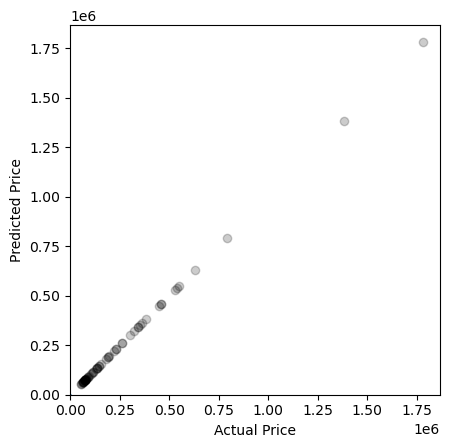

In [699]:
plt.scatter(y_val, y, c='k', alpha = 0.2)      #산점도 (Scatter plot)는 두 변수의 상관 관계를 직교 좌표계의 평면에 점으로 표현하는 그래프
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.axis("equal")
plt.axis("square")
plt.xlim([0, plt.xlim()[1]])
plt.ylim([0, plt.ylim()[1]])
_= plt.plot([-100,100],[-100,100])
plt.show()

In [ ]:
plt.scatter(x, y, c='k')      #산점도 (Scatter plot)는 두 변수의 상관 관계를 직교 좌표계의 평면에 점으로 표현하는 그래프
plt.plot(xs, model_dt.predict(xs), c='r')  #실제로 그래프를 시각화함 (xs와 predict(xs)를 가지고 빨간색 라인으로 그래프를 나타냄)
plt.show()